Imports

In [1]:
import pandas as pd
import numpy as np
import data_loader as m
import thermal_compensation as TC

User Inputs

In [2]:
machine = 'SwissDECO'

trainingNumber = 4

trainingDate = '2023.05.02'

errorName = 'X1-2'

bad_machineTemperatures_sensors = ['S1 - Casting','NC','Main Gang 3','Turret','S11 - Casting','Spindle Area','Main Gang 2','Turret - Back 2','S41 - Top', 'S41 - Rear 1', 'S41 - Rear 2', 'S41 - Bottom 1', 'S41 - Bottom 2', 'S41 - Radial Tool', 'S41 - T411', 'S41 - T414','S41 - T65', 'S41 - T68','Room Temperature', 'Cooling', 'S1 - Bottom']

uncorrelated_motorsTemperatures_sensors = ['S1', 'S11', 'S21', 'S4', 'S41']

ballScrewsNames = ['X1-BS','X2-BS','Z2-BS','Y4-BS','Z4-BS']

train_start = 0
train_end   = 399
pred_start  = train_end+1

e_threshold   = 10  # User requirements for accuracy
std_threshold = 25  # User tolerance for uncertainty
N_skip        = 2   # Improvement in efficiency by lowering number of measurements


Load Data

In [3]:
errors = m.Measurement('errors',trainingNumber,trainingDate,machine)
errors.load_measurement(errorName,zero_normalize=True)
global_time = errors.get_global_time()

ballScrews = m.Measurement('errors',trainingNumber,trainingDate,machine)
ballScrews.load_measurement(ballScrewsNames,zero_normalize=True)

machineTemperatures = m.Measurement('machineTemperatures',trainingNumber,trainingDate,machine)
machineTemperatures.load_measurement(global_time=global_time,remove_sensors=bad_machineTemperatures_sensors,zero_normalize=True)

motorsTemperatures =  m.Measurement('motorsTemperatures',trainingNumber,trainingDate,machine)
motorsTemperatures.load_measurement(global_time=global_time,zero_normalize=True)


Loading errors finished.
Loading errors finished.
Loading machineTemperatures finished.
Loading motorsTemperatures finished.


Smooth

In [4]:
errors.smooth()
machineTemperatures.smooth()
motorsTemperatures.smooth()

Create datasets

In [5]:
df_X = pd.concat((machineTemperatures.df,motorsTemperatures.df),axis=1)
df_y = errors.df.to_frame()*1000

Thermal Compensation

In [6]:
compensation = TC.Thermal_Compensation()
compensation.set_train_start(train_start)
compensation.set_train_end(train_end)
compensation.set_e_threshold(e_threshold)
compensation.set_std_threshold(std_threshold)
compensation.set_N_skip(N_skip)
compensation.append_data(df_X,df_y)

Train model

In [7]:
compensation.train_model()

C:\Users\pkaftan\AppData\Roaming\Python\Python39\site-packages\torch\autograd\graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Final loss: -2.523523855795905


Predict

In [8]:
compensation.predict(recalibrations=True)

Plot result

In [9]:
compensation.y_std.shape

(2490,)

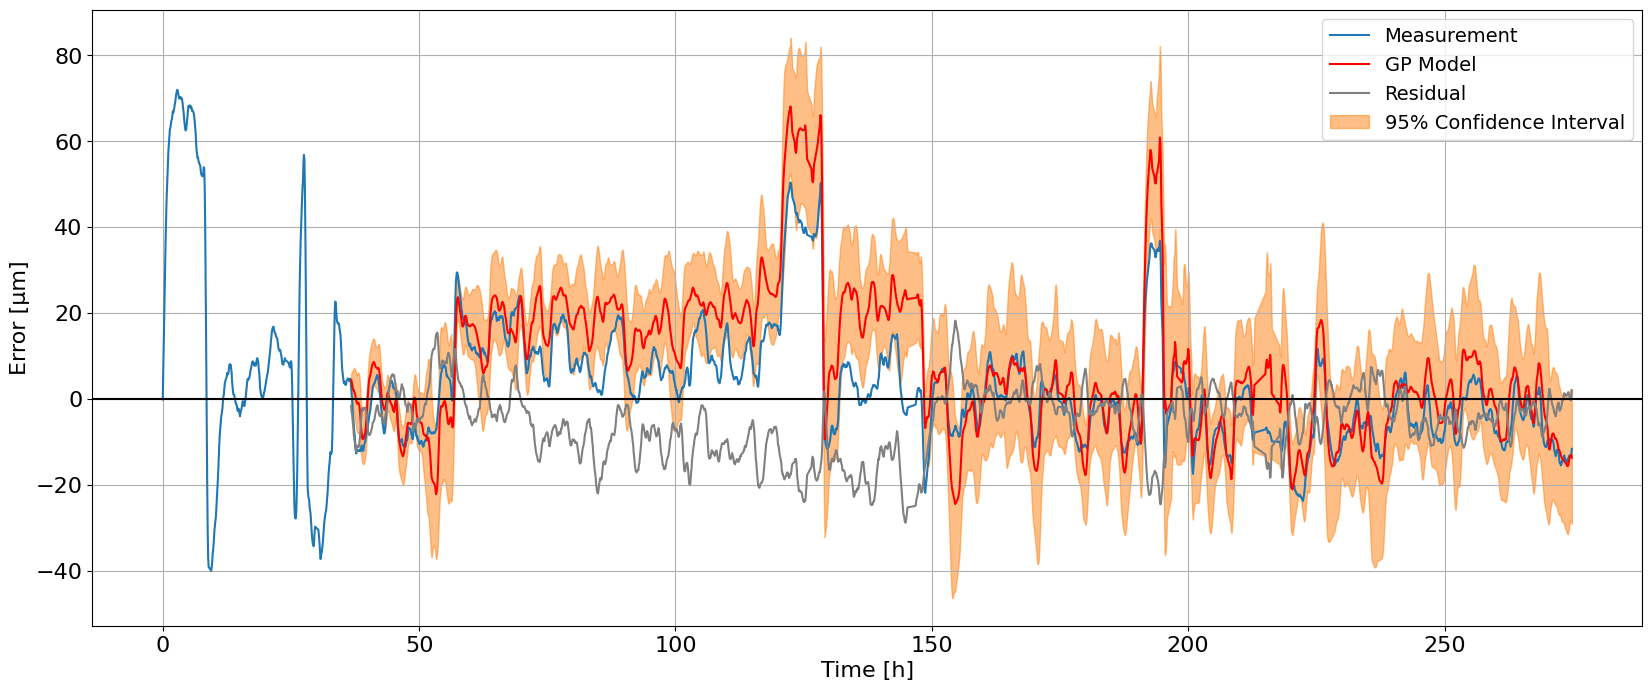

In [10]:
compensation.plot_result()

Calculate Statistics

In [11]:
mae = round(np.mean(np.abs(y_resi)), 1)
rms = round(np.sqrt(np.mean(y_resi**2)), 1)
p2p = round(np.max(y_resi) - np.min(y_resi), 1)
print('MAE: ' + str(mae) + ' μm')
print('RMS: ' + str(rms) + ' μm')
print('P2P: ' + str(p2p) + ' μm')
print(f"Execution time: {elapsed_time:.2f} seconds")
print('N recalibrations:', len(idx_recalibrations))

# Define filename based on y_threshold
filename = f"logs/log_std_threshold_{std_threshold}.txt"

# Save to log file using default encoding
with open(filename, 'w') as f:
    f.write(f"MAE: {mae} um\n")
    f.write(f"RMS: {rms} um\n")
    f.write(f"P2P: {p2p} um\n")
    f.write(f"Execution time: {elapsed_time:.2f} seconds\n")
    f.write(f"N recalibrations: {len(idx_recalibrations)}\n")

print(f"Log saved to {filename}")

NameError: name 'y_resi' is not defined

Plot standard deviation

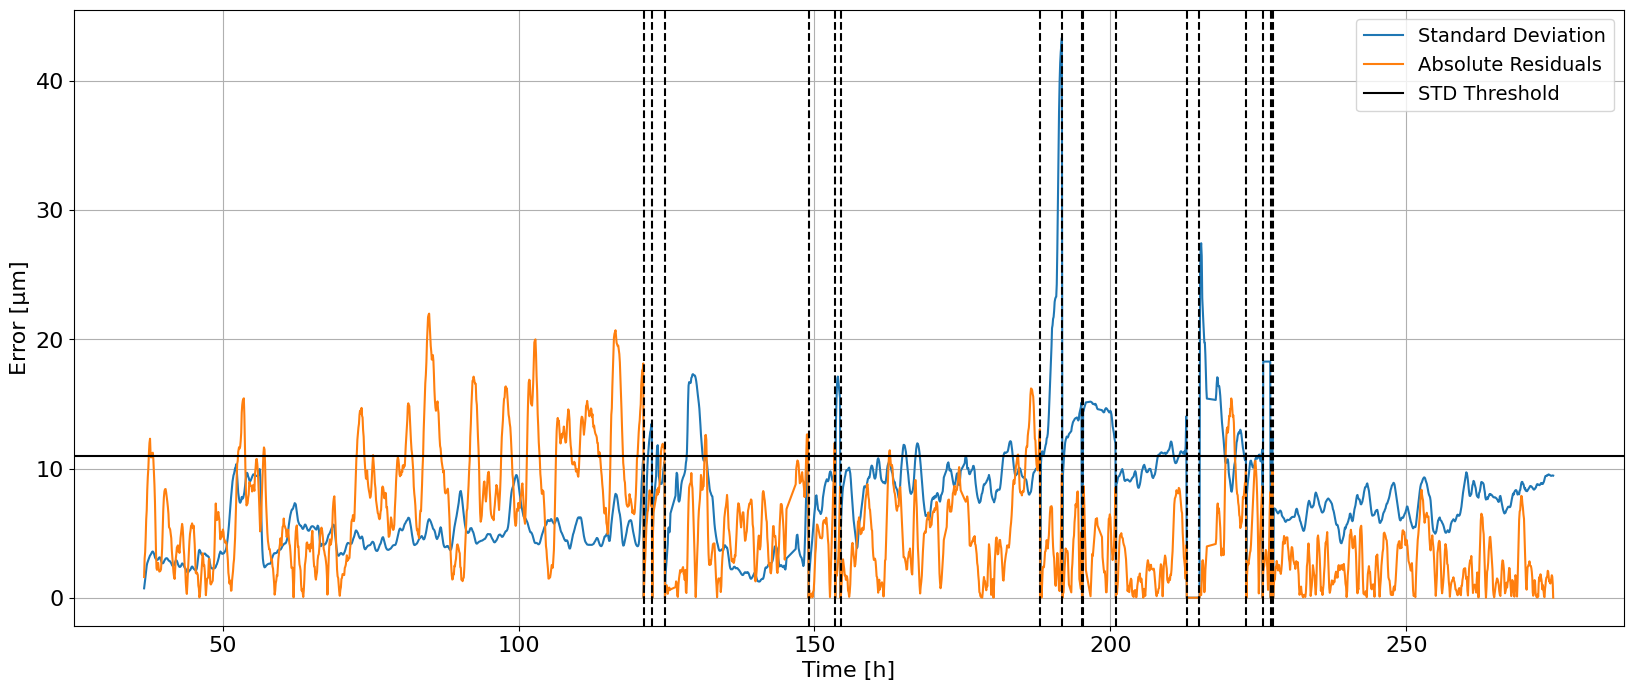

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(t_pred, y_std, label="Standard Deviation")
plt.plot(t_pred, np.abs(y_resi), label="Absolute Residuals")
plt.axhline(std_threshold, color='black', label="STD Threshold")

for x in idx_recalibrations:
    plt.axvline(x=t[x], color='black', linestyle='--')

plt.legend(fontsize=14)
plt.xlabel('Time [h]', fontsize=16)
plt.ylabel('Error [μm]', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.grid()

# Define the filename with dynamic content
figName = f'TDC_{machine}_{trainingDate}_{errorName}_std_threshold={std_threshold}_std_plot.png'

# Save the figure to the "figures" folder
plt.savefig(f'figures/{figName}', bbox_inches='tight', dpi=300)

Save .csv files

In [ ]:
from pathlib import Path

SAVE = True
if SAVE == True:
    folder = Path(f"results/std_threshold={std_threshold}")
    folder.mkdir(parents=True, exist_ok=True)

    save_t      = pd.DataFrame(t)
    save_t_pred = pd.DataFrame(t_pred)
    save_std_pred = pd.DataFrame(y_std)
    save_y_pred = pd.DataFrame(y_pred)
    save_y      = pd.DataFrame(y)
    save_y_resi = pd.DataFrame(y_resi)
    save_idx_recalibrations = pd.DataFrame(idx_recalibrations)

    save_t.to_csv(folder / f't_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_t_pred.to_csv(folder / f't_pred_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_std_pred.to_csv(folder / f'std_pred_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_y_pred.to_csv(folder / f'y_pred_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_y.to_csv(folder / f'y_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_y_resi.to_csv(folder / f'y_resi_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
    save_idx_recalibrations.to_csv(folder / f'idx_recalibrations_{errorName}_stdTrigger_{std_threshold}.csv', header=False, index=False)
